#Packages

In [1]:
# Loading required Packages

!pip install rdkit

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from datetime import datetime


!pwd


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 6.8 MB/s eta 0:00:00
/content


#Functions

In [2]:
# This function converts smiles strings into 2048 bit Morgan fingerprints (radius = 2):

def smiles_to_fp(smiles, radius=2, n_bits=2048):
    """Encode a molecule from a SMILES string into a fingerprint.

    Args:
      smiles (str): SMILES string defining the molecule.
      radius (int): Radius for the fingerprint
      n_bits (int): Length of the fingerprint.

    Returns:
      The fingerprint as numpy array.
    """
    mol = Chem.MolFromSmiles(smiles)
    rdkgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
    return rdkgen.GetFingerprintAsNumPy(mol)

#Main Code

In [3]:
# Read in the dataset modified by Sven, already standardized SMILES

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/allassays_nodupl_nofrag.csv', sep=',', usecols =['Molecule ChEMBL ID','Smiles','Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'AlogP','Molecular Weight','Assay Description', 'pIC50'])

# Featurizes with the Morgan fingerprint function above and converts the DataFrame columns into numpy arrays which can be used for machine learning

df['fingerprint'] = df['Smiles'].apply(smiles_to_fp)
X = np.array(df['fingerprint'].tolist()) # Feature = Morgan Fingerprint
y = np.array(df['pIC50']) # Target = pIC50

# Splitting into 70%/15%/15% training/validation/test sets

X_train_tot, X_test, y_train_tot, y_test = train_test_split(X, y, test_size=0.15, random_state=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_tot, y_train_tot, test_size=0.18, random_state=22)

StartTime: 2024-06-27 20:18:07.340425


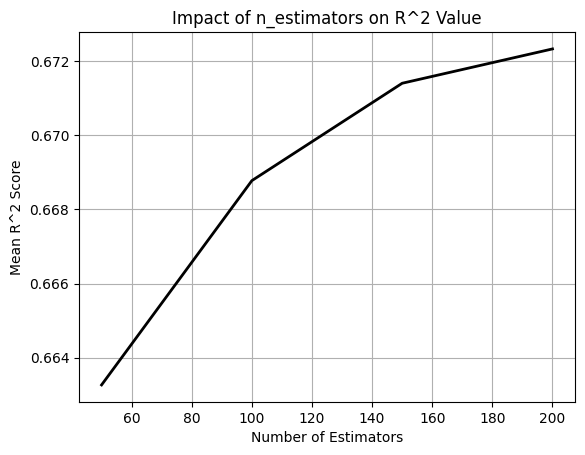

EndTime: 2024-06-27 20:21:04.629753


In [4]:
# Impact of n_estimators on R^2 value
StartTime = datetime.now()
print("StartTime:", StartTime)

# Perform 3-fold cross-validation with R-squared as the scoring metric
n_estimators_list = [50, 100, 150, 200]
kf2 = KFold(n_splits=3, shuffle=True, random_state=9)
mean_r2_scores = np.zeros(len(n_estimators_list))

for idx, n_estimators in enumerate(n_estimators_list):
    model_rf = RandomForestRegressor(n_estimators=n_estimators, max_features = 1, random_state=42, n_jobs=-1)
    r2_scores = cross_val_score(model_rf, X, y, cv=kf2, scoring='r2')
    mean_r2_scores[idx] = r2_scores.mean()

# Plot the results
plt.plot(n_estimators_list, mean_r2_scores, color='black', linewidth=2)
plt.xlabel('Number of Estimators')
plt.ylabel('Mean R^2 Score')
plt.title('Impact of n_estimators on R^2 Value')
plt.grid(True)
plt.show()  # Render the plot

EndTime = datetime.now()
print("EndTime:", EndTime)

In [6]:
# Grid search with 3-fold cross-validation
StartTime = datetime.now()
print("StartTime :", StartTime)

rf = RandomForestRegressor(random_state= 42)
# Take default settings as the most important parameters are n_esimator and max_features => take n_estimator = 100 from above (time vs. accuracy)
param_grid = {
    'max_features': [1, 'log2', 'sqrt'],     # Number of features to consider at each split
    'min_samples_leaf': [1, 2, 4],       # Minimum number of samples required to be at a leaf node
    'min_samples_split': [2, 5, 10]
}

# Initialise KFold
kf = KFold(n_splits=3, shuffle=True, random_state=12)

# Perform grid search with 3-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring='r2', verbose=1)
grid_search.fit(X, y)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)
print("Best Estimator:", best_model)

EndTime = datetime.now()
print("EndTime :", EndTime)

StartTime : 2024-06-27 20:28:48.304274
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Estimator: RandomForestRegressor(max_features='sqrt', random_state=42)
EndTime : 2024-06-27 20:58:04.032270


In [ ]:
# Cross validation to find mean R^2 and Standard deviation
StartTime = datetime.now()
print("StartTime :", StartTime)

# Perform 3-fold cross-validation with R-squared as the scoring metric
model_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)

# CV for model evaluation with different split
kf2 = KFold(n_splits=3, shuffle=True, random_state=3)
r2_scores = cross_val_score(model_rf, X, y, cv=kf2, scoring='r2')

# Calculate the mean R-squared across all folds
mean_r2 = r2_scores.mean()
std_r2 = np.std(r2_scores)

print("R-squared values for each fold:", r2_scores)
print("Mean R-squared:", mean_r2)
print("Standard deviation", std_r2)

EndTime = datetime.now()
print("EndTime :", EndTime)

StartTime : 2024-06-27 14:30:34.139375
R-squared values for each fold: [0.71181399 0.71088963 0.68823376]
Mean R-squared: 0.7036457937397977
Standard deviation 0.010904485782010243
EndTime : 2024-06-27 14:32:51.293621
